## Import the necessary libraries

In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten

from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

2023-03-06 12:35:09.785707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 12:35:10.087554: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-06 12:35:10.155944: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-06 12:35:10.868685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

2.10.1


/home/bakary/anaconda3/envs/outlier/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparations

### Good images dataset

In [2]:
image_directory = 'carpet/train/'
SIZE = 64
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  

good_images = os.listdir(image_directory + 'good/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'good/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))

dataset = np.array(dataset)

In [3]:
train = dataset[0:200]
test1 = dataset[200:279]

train = train.astype("float32") / 255.0
test1 = test1.astype("float32") / 255.0

#Let us also load bad images to verify our trained model. 



### Bad image dataset

In [4]:
image_directory = 'carpet/test/'

bad_images = os.listdir(image_directory + 'color')
bad_dataset=[]
for i, image_name in enumerate(bad_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'color/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        bad_dataset.append(np.array(image))
bad_dataset = np.array(bad_dataset)
bad_dataset = bad_dataset.astype('float32') / 255.

### Good and bad image dataset

In [5]:
image_directory = 'good_and_bad/'

good_bad_images = os.listdir(image_directory + 'g_and_b')
good_bad_dataset=[]
for i, image_name in enumerate(good_bad_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'g_and_b/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        good_bad_dataset.append(np.array(image))
good_bad_dataset = np.array(good_bad_dataset)
good_bad_dataset = good_bad_dataset.astype('float32') / 255.

### Define the encoder

In [6]:
encoding_dim = 1024  #Dimension of the bottleneck encoder vector. 
dense_dim = [8, 8, 512] #Dimension of the last conv. output. This is used to work our way back in the decoder. 


encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

print(encoder_net.summary())
#print(encoder_net.input_shape)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         1049088   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
Total params: 34,738,880
Trainable params: 34,738,880
Non-trainable params: 0
_________________________________________________________________
None


2023-03-06 12:35:27.839957: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-06 12:35:27.839998: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bakary-Allahu-Akbar): /proc/driver/nvidia/version does not exist
2023-03-06 12:35:27.841388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Define the decoder.

In [7]:
 
#Start with the bottleneck dimension (encoder vector) and connect to dense layer 
#with dim = total nodes in the last conv. in the encoder. 
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

print(decoder_net.summary())
#print(decoder_net.input_shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             33587200  
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       262208    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 3)        3075      
 ranspose)                                                       
                                                      

### initialize outlier detector(od) THIS IS OUR MODEL FOR THE OUTLIER DETECTION

In [8]:
latent_dim = 1024  #(Same as encoding dim. )
# initialize outlier detector(od) THIS IS OUR MODEL FOR THE OUTLIER DETECTION

od = OutlierVAE(threshold=.015,  # threshold for outlier score above which the element is flagged as an outlier.
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=4)

print("Current threshold value is: ", od.threshold)


Current threshold value is:  0.015


### Train the on good images autoencoder

In [9]:
# train
#from alibi_detect.models.tensorflow.losses import elbo #evidence lower bound loss

adam = tf.keras.optimizers.Adam(lr=1e-4)

od.fit(train,
       optimizer = adam,
       epochs=20,
       batch_size=4,
       verbose=True)

/home/bakary/anaconda3/envs/outlier/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


50/50 [=] - 10s 196ms/step - loss_ma: -20106.7858


In [10]:

#Check the threshold value. Should be the same as defined before. 
print("Current threshold value is: ", od.threshold)

Current threshold value is:  0.015


#### infer_threshold Updates threshold by a value inferred from the percentage of instances considered to be outliers in a sample of the dataset. Since we have no idea  about what a ggod threshold could be. percentage of X considered to be normal based on the outlier score. Here, we set it to 99%

In [11]:
od.infer_threshold(test1, outlier_type='instance', threshold_perc=99.0)
print("Current threshold value is: ", od.threshold)

Current threshold value is:  0.003284132797271013


### save the trained outlier detector


#### As mentioned in their documentation, save and load is having issues in python3.6 but works fine in 3.7


If this does not work, try the next line

In [12]:
from alibi_detect.utils.saving import save_detector, load_detector #Use this if the above line does not work. 
save_detector(od, "Desktop/My_GitHub/Image_outlier/carpet_od_20epochs.h5")
od = load_detector("Desktop/My_GitHub/Image_outlier/carpet_od_20epochs.h5")

### Test our model on a bad image

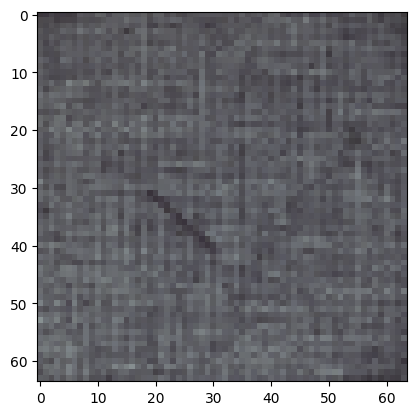

In [13]:

img_num = 9
test_bad_image = bad_dataset[img_num].reshape(1, 64, 64, 3)
plt.imshow(test_bad_image[0])


###  Lets Reconstruct the bad image

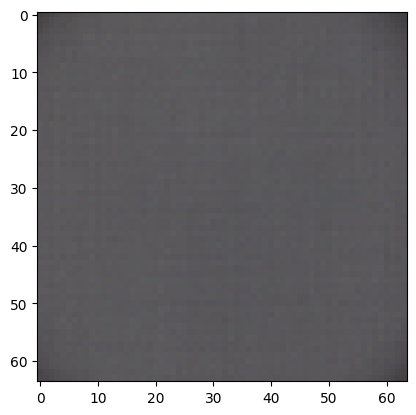

In [14]:

test_bad_image_recon = od.vae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy() # When reconstructing an image, it automatically
# turns into a tensor image. Therefore, we need to convert it back to a numpy array to be able to plot it
plt.imshow(test_bad_image_recon[0])


### Let predict to see if the reconstructed image is image or not. This will Returns a dictionary of data and metadata

In [15]:
test_bad_image_predict = od.predict(test_bad_image) 

#### Data dictionary contains the instance_score, feature_score, and whether it is an outlier or not.  Let u look at the values under the 'data' key in our output dictionary

In [16]:

bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
print("The instance score is:", bad_image_instance_score)

The instance score is: 0.0024392784


Is this image an outlier (0 for NO and 1 for YES)? 0


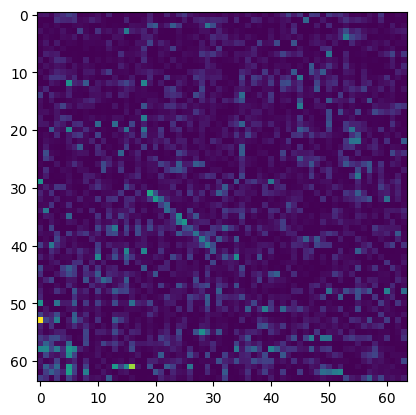

In [17]:
bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(bad_image_feature_score[:,:,0])
print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])
#print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])


#### You can also manually define the threshold based on your specific use case.

In [67]:
 

print("Current threshld value is: ", od.threshold)

Current threshld value is:  0.002


### Let us check the outlier on for multiple bad images

['instance_score', 'feature_score', 'is_outlier']


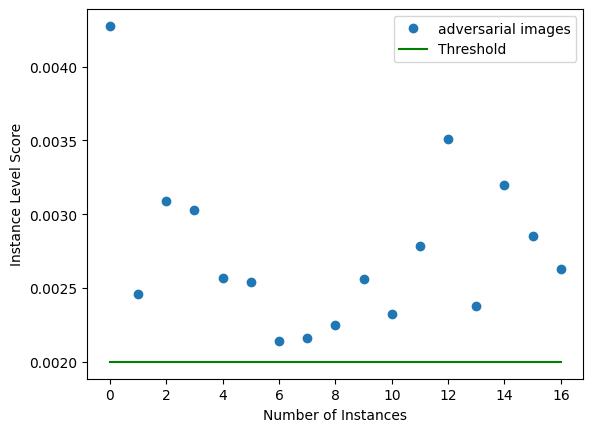

In [72]:
od.threshold = 0.002
X = bad_dataset[:17]

od_preds1 = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

print(list(od_preds1['data'].keys()))


target = np.ones(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'adversarial images']
plot_instance_score(od_preds1, target, labels, od.threshold) #pred, target, labels, the current threshold


# for each image, demonstrating if there is outliers or not.

### Scatter plot of instance scores. using the built-in function for the scatterplot. 

In [ ]:
### Plot features for select bad images, using the built in function (plot_feature_outlier_image)

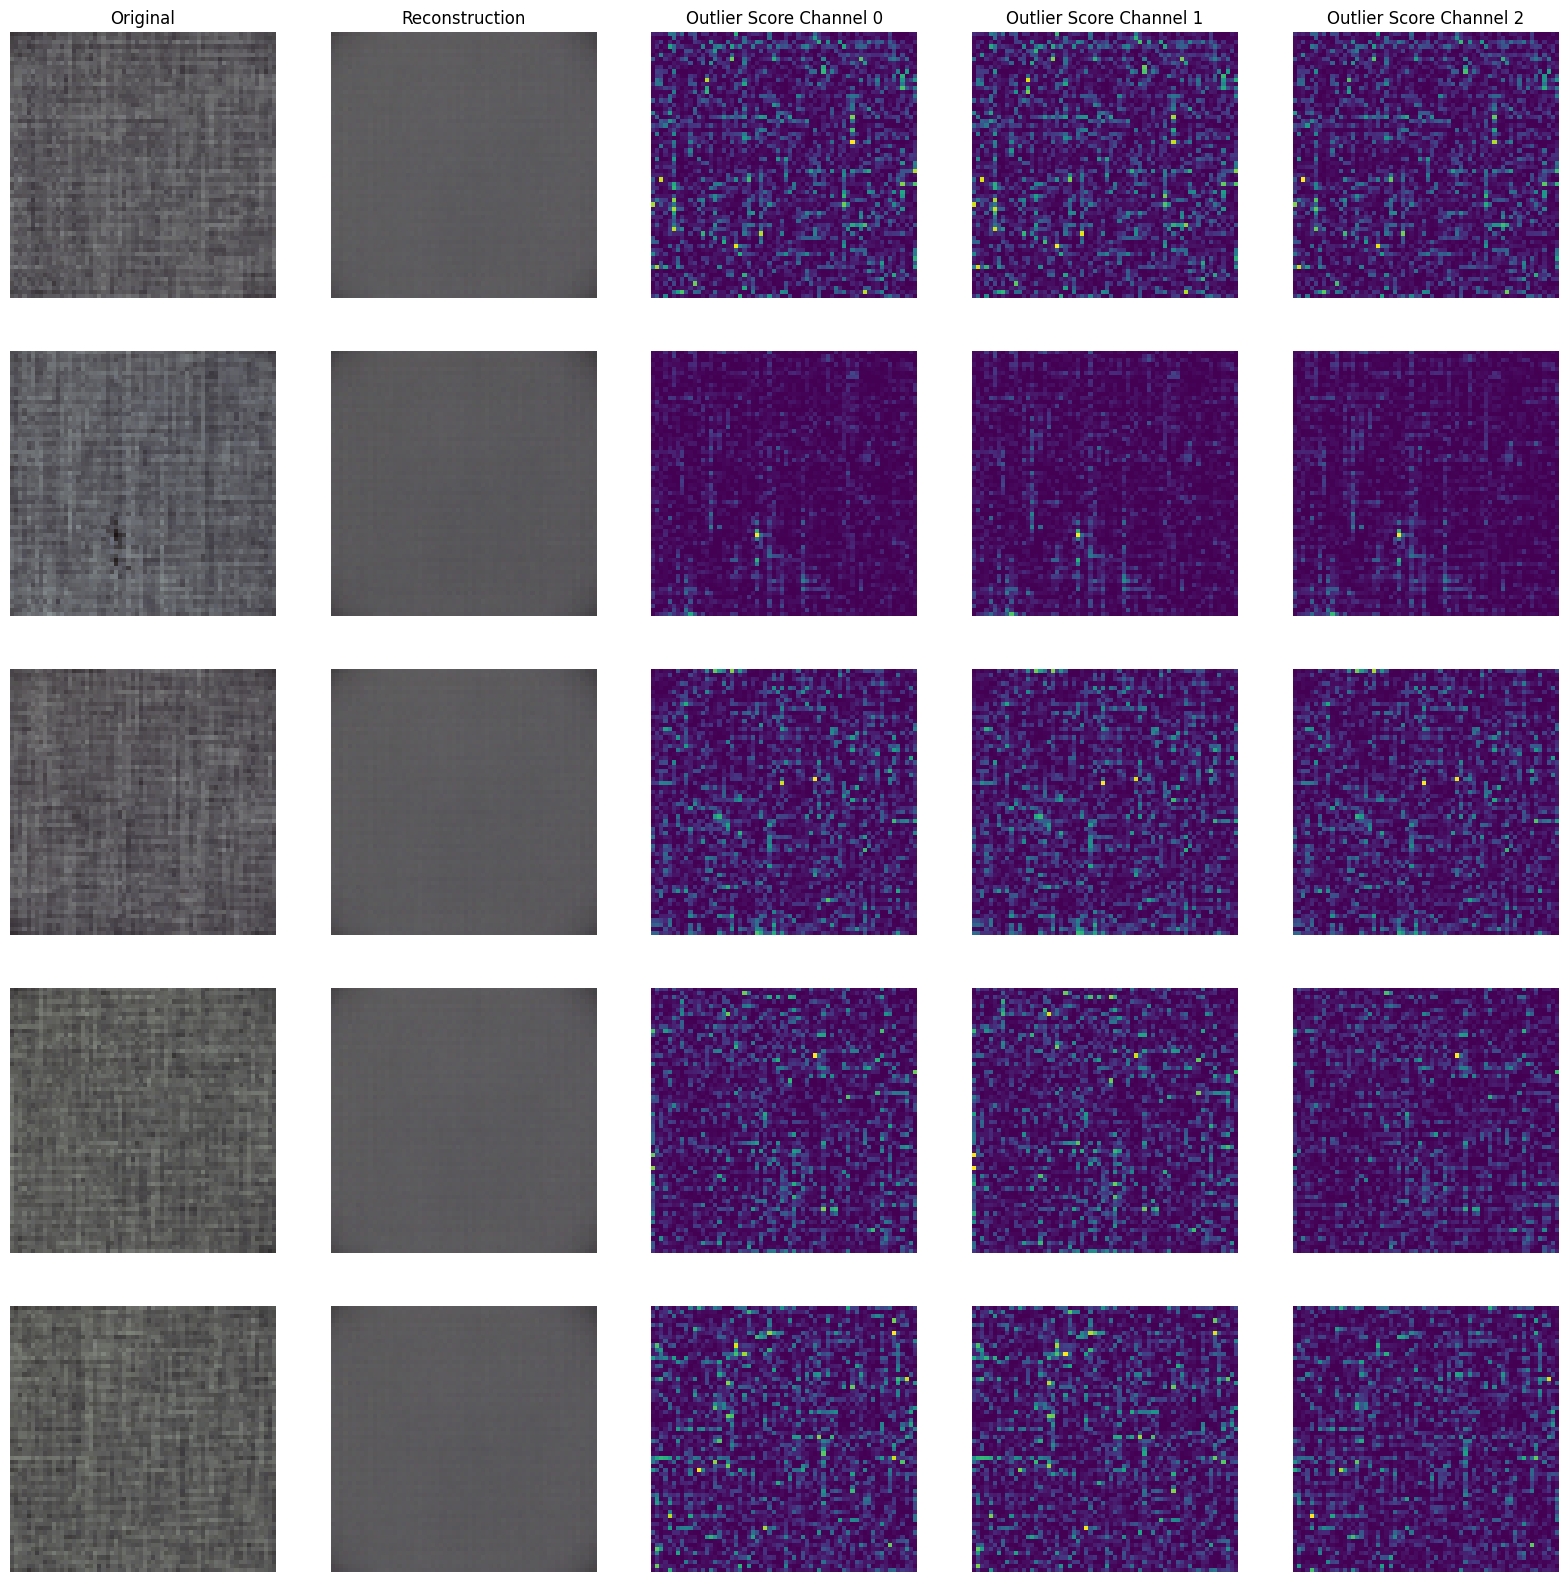

In [47]:

X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           instance_ids=[0, 5, 10, 15, 16],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions


### Good and bad images with a threshold of 0.003

['instance_score', 'feature_score', 'is_outlier']


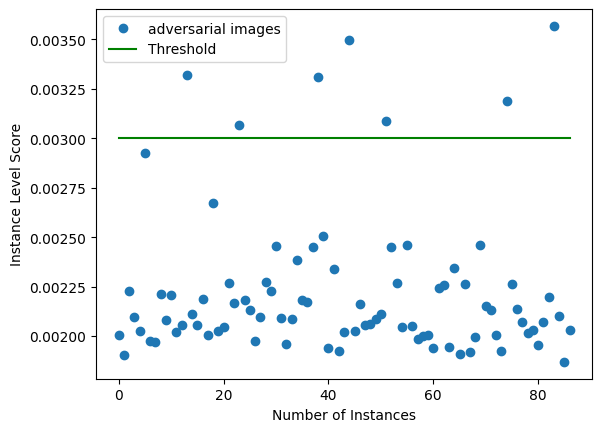

In [49]:
od_threshold = 0.003
X = good_bad_dataset[:88]

od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

print(list(od_preds['data'].keys()))

target = np.ones(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'adversarial images']

# Create a list of colors based on the instance scores
colors = ['red' if score > od_threshold else 'green' for score in od_preds['data']['instance_score']]

# Use the color argument to specify the color of each point on the scatter plot
plot_instance_score(od_preds, target, labels, od_threshold)


/tmp/ipykernel_28563/943992002.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(range(1, len(scores)+1), scores, c=colors, cmap='coolwarm', alpha=0.7)


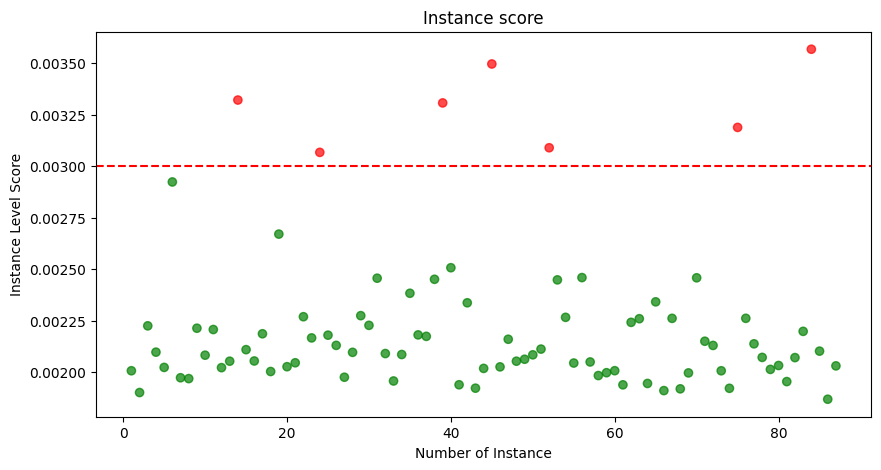

In [88]:
import numpy as np
import matplotlib.pyplot as plt

def plot_instance_score_with_color(preds, target, labels, threshold, color=None):
    scores = preds['data']['instance_score']
    colors = np.where(scores > threshold, 'r', 'g')
    plt.figure(figsize=(10, 5))
    plt.scatter(range(1, len(scores)+1), scores, c=colors, cmap='coolwarm', alpha=0.7)
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.title('Instance score')
    plt.ylabel('Instance Level Score')
    plt.xlabel('Number of Instance')
    plt.show()


# Use the color argument to specify the color of each point on the scatter plot
plot_instance_score_with_color(od_preds, target, labels, od_threshold)


/tmp/ipykernel_28563/440005622.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(range(1, len(scores)+1), scores, c=colors, cmap='coolwarm', alpha=0.7)


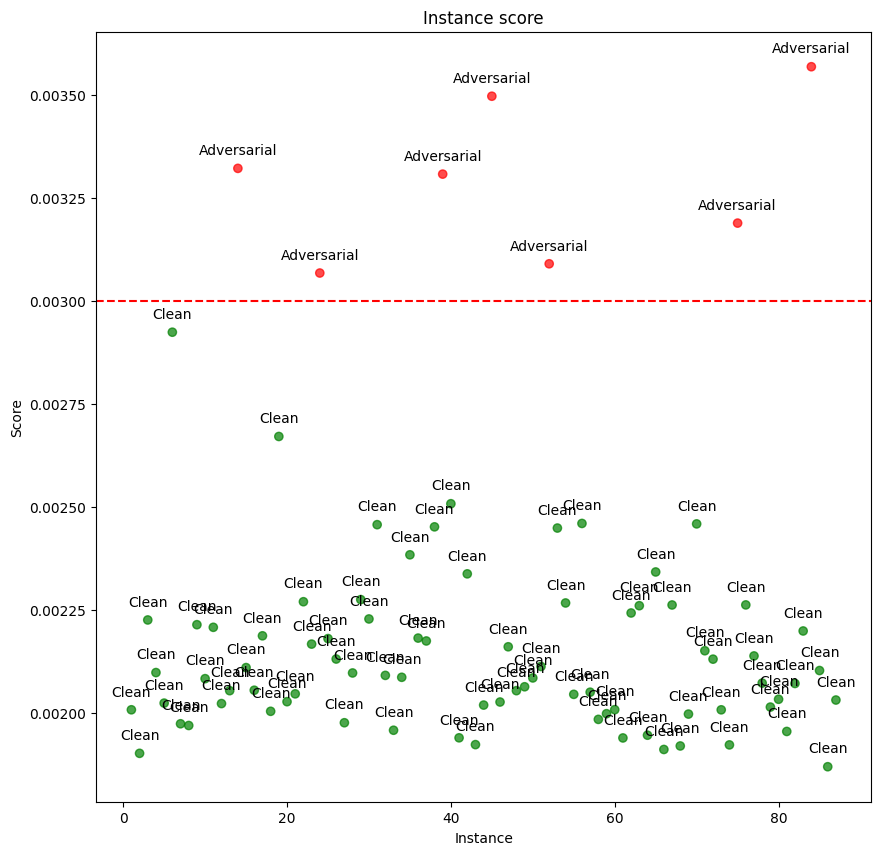

In [61]:

import numpy as np
import matplotlib.pyplot as plt

def plot_instance_score_with_color(preds, target, labels, threshold, color=None):
    scores = preds['data']['instance_score']
    colors = np.where(scores > threshold, 'r', 'g')
    labels = np.where(scores > threshold, 'Adversarial', 'Clean')
    plt.figure(figsize=(10, 10))
    plt.scatter(range(1, len(scores)+1), scores, c=colors, cmap='coolwarm', alpha=0.7)
    plt.axhline(y=threshold, color='r', linestyle='--')
    for i in range(len(scores)):
        plt.annotate(labels[i], (i+1, scores[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)
    plt.title('Instance score')
    plt.ylabel('Score')
    plt.xlabel('Instance')
    plt.show()

# Use the color argument to specify the color of each point on the scatter plot
plot_instance_score_with_color(od_preds, target, labels, od_threshold)


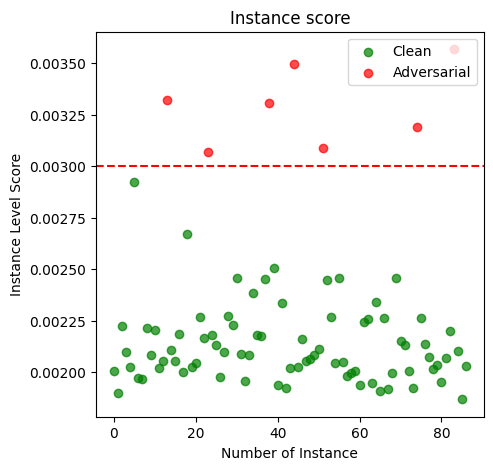

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def plot_instance_score_with_color(preds, target, labels, threshold, color=None):
    scores = preds['data']['instance_score']
    colors = np.where(scores > threshold, 'r', 'g')
    clean_indices = np.where(scores <= threshold)
    adv_indices = np.where(scores > threshold)

    plt.figure(figsize=(5, 5))
    plt.scatter(clean_indices, scores[clean_indices], c='g', alpha=0.7, label='Clean')
    plt.scatter(adv_indices, scores[adv_indices], c='r', alpha=0.7, label='Adversarial')
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.title('Instance score')
    plt.ylabel('Instance Level Score')
    plt.xlabel('Number of Instance')
    plt.legend(loc='upper right')
    plt.show()

# Use the color argument to specify the color of each point on the scatter plot
plot_instance_score_with_color(od_preds, target, labels, od_threshold)


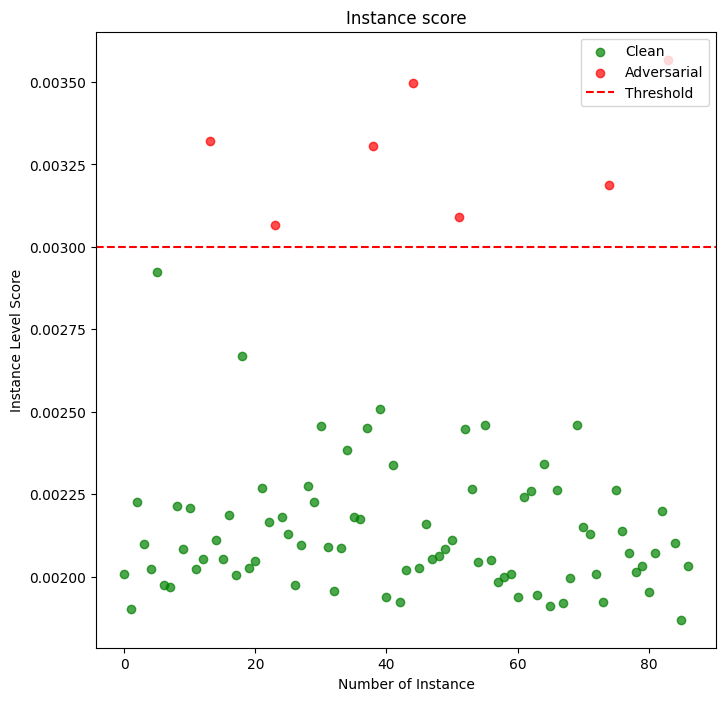

In [64]:
import numpy as np
import matplotlib.pyplot as plt

def plot_instance_score_with_color(preds, target, labels, threshold, color=None):
    scores = preds['data']['instance_score']
    colors = np.where(scores > threshold, 'r', 'g')
    clean_indices = np.where(scores <= threshold)
    adv_indices = np.where(scores > threshold)

    plt.figure(figsize=(8, 8))
    plt.scatter(clean_indices, scores[clean_indices], c='g', alpha=0.7, label='Clean')
    plt.scatter(adv_indices, scores[adv_indices], c='r', alpha=0.7, label='Adversarial')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Instance score')
    plt.ylabel('Instance Level Score')
    plt.xlabel('Number of Instance')
    plt.legend(loc='upper right')
    plt.show()

# Use the color argument to specify the color of each point on the scatter plot
plot_instance_score_with_color(od_preds, target, labels, od_threshold)
